In [1]:
import numpy as np
import pandas as pd

np.random.seed(0)
!pip install opencv-python

%load_ext autoreload
%autoreload 2

In [2]:
from torchvision import datasets
data = datasets.MNIST(root='data', download=True)
X, y = data.data, data.targets


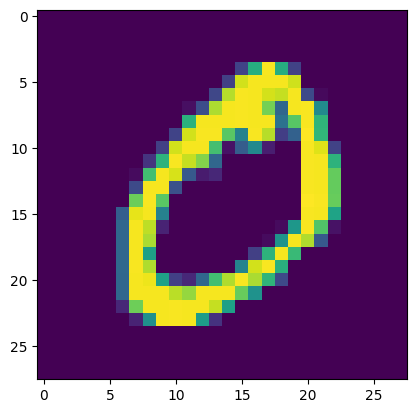

In [3]:
import matplotlib.pyplot as plt
plt.imshow(X[1])
plt.show()

# Pre-processing


Check how balanced the data is 

In [4]:
pd.DataFrame(y).value_counts()

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
dtype: int64

In [5]:
def preprocess(X):
    # np.array(data[0]).flatten()
    X = X.reshape(len(X), -1)
    X = np.array(X)
    return X

def normalize(X):
    X = X/255
    return X

def standardize(X): # improves accuracy by 7 to 10%
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    return X

def pipeline(X):
    X = preprocess(X)
    # X = normalize(X)
    return X

X = pipeline(X)

"""
normalize: 0.48
normalize + standardize: 0.59
"""

'\nnormalize: 0.48\nnormalize + standardize: 0.59\n'

### Train-test split

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_testrain, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sobel edge detection, doesn't improve results that much but takes a long time

In [7]:
# import cv2
# import numpy as np

# # Assuming X_train is originally flattened to (n_samples, 784)
# # We first reshape it to (28, 28) for image processing
# X_train_reshaped = X_train.reshape(-1, 28, 28)  # Reshape to 28x28 images

# X_train_sobelx = np.zeros_like(X_train_reshaped)
# X_train_sobely = np.zeros_like(X_train_reshaped)

# for i in range(len(X_train_reshaped)):
#     # Convert to uint8, necessary for certain OpenCV functions
#     img_uint8 = np.uint8(X_train_reshaped[i])
    
#     # Apply Sobel operator in the X and Y directions
#     sobelx = cv2.Sobel(src=img_uint8, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5)
#     sobely = cv2.Sobel(src=img_uint8, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=5)
    
#     # Convert back to uint8 and take absolute value to form a proper image
#     sobelx = np.uint8(np.absolute(sobelx))
#     sobely = np.uint8(np.absolute(sobely))
    
#     # Store in arrays after ensuring the shape matches
#     X_train_sobelx[i] = sobelx
#     X_train_sobely[i] = sobely

# # Optionally, if you need to flatten these for a machine learning model expecting 1D features per sample:
# X_train_sobelx = X_train_sobelx.reshape(-1, 784)
# X_train_sobely = X_train_sobely.reshape(-1, 784)
# X_train_combined = np.concatenate((X_train, X_train_sobelx, X_train_sobely))
# X_train = X_train_combined


### Model training

after running this notebook many times I found that the higher the n_clusters, the better the accuracy

In [8]:
n_clusters = 50

the following code block is used for profiling (seeing which lines take the longest to run). the results show that distance calculation takes the most time

In [9]:
# from KMeans import KMeans
# from line_profiler import LineProfiler

# def profile_fit():
#     kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter = 300, tol = 1e-4)
#     kmeans.fit(X_train)

# # Create a LineProfiler object and pass the function to be profiled
# lp = LineProfiler()
# lp.add_function(KMeans.fit)  # Explicitly add the KMeans fit method if you want to profile it too
# lp_wrapper = lp(profile_fit)
# lp_wrapper()

# # Print the results
# lp.print_stats()


In [10]:
from sklearn.cluster import KMeans as KMeans_sk
kmeans_sk = KMeans_sk(n_clusters=n_clusters)
kmeans_sk.fit(X_train)

KMeans(n_clusters=50)

In [11]:
from KMeans import KMeans

kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter = 300, tol = 1e-4)
kmeans.fit(X_train)

In [12]:
y_pred = kmeans.predict(X_test)
y_pred_sk = kmeans_sk.predict(X_test)

### Assigning labels to clusters

In [13]:
def assign_labels(y_pred, y_test):
    cluster_labels = {}
    for i in range(n_clusters):
        if len(y_test[y_pred == i]) == 0:
            cluster_labels[i] = -1  # Assign a default label
            continue
        label = pd.DataFrame(y_test[y_pred == i]).value_counts().idxmax()
        cluster_labels[i] = label[0]

    labeled_y_pred = np.array(list(map(lambda x: cluster_labels.get(x, -1), y_pred)))
    return labeled_y_pred

y_pred = assign_labels(y_pred, y_test)
if 'y_pred_sk' in globals():
    y_pred_sk = assign_labels(y_pred_sk, y_test)

### Evaluation

In [14]:
from sklearn.metrics import accuracy_score
print("KMeans accuracy:", accuracy_score(np.array(y_test), y_pred))
if 'y_pred_sk' in globals():
    print("Sklearn KMeans acurracy:", accuracy_score(y_test, y_pred_sk))

KMeans accuracy: 0.8076666666666666
Sklearn KMeans acurracy: 0.8195


another way to calculate accuracy

In [15]:
(np.array(y_pred) == np.array(y_test)).mean()

0.8076666666666666

a cooler way to calculate accuracy

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred).diagonal().sum()/len(y_test)

0.8076666666666666

### Plotting the first 9 samples classified as 0

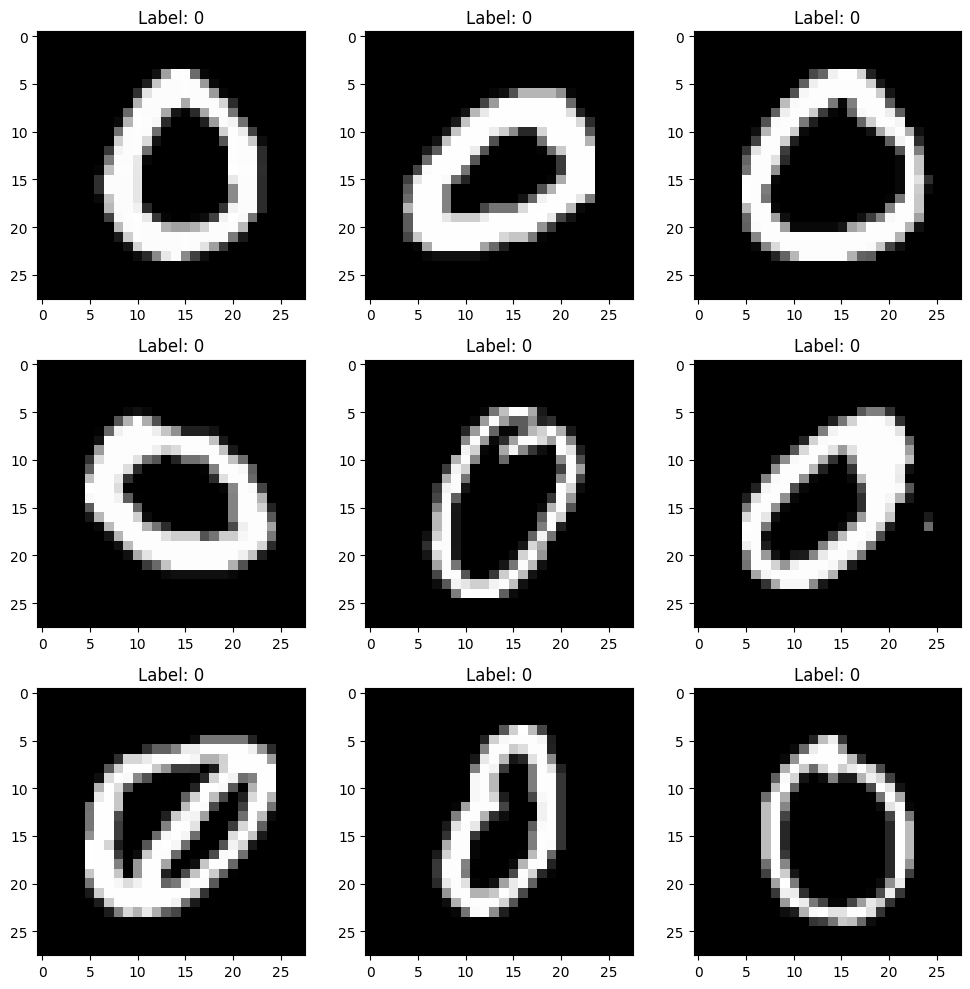

In [25]:
indices = np.where(y_test == 0)[0][:9]

fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i, index in enumerate(indices):
    image = X_test[index]
    label = y_test[index]

    image = image.reshape(28, 28)

    ax = axs[i // 3, i % 3]
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Label: {label}")

for i in range(9, len(axs.flat)):
    axs.flat[i].axis('off')

plt.tight_layout()
plt.show()

### Confusion matrix

In [26]:
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_test, y_pred)
confusion_mat


array([[1031,    0,   23,    6,    1,   64,   41,    0,    9,    0],
       [   0, 1292,   11,    5,    1,    1,    1,    3,    6,    2],
       [   4,   22, 1081,   10,    3,    5,    6,   15,   27,    1],
       [   4,    6,   41,  948,    4,  103,    4,   19,   82,    8],
       [   0,   11,   43,    2,  753,    4,   16,   86,    1,  260],
       [   6,    8,   45,   79,    7,  907,    8,    3,   34,    7],
       [  10,    3,   33,    2,    2,   32, 1092,    0,    3,    0],
       [   1,   36,   38,    0,   30,    2,    0, 1145,    5,   42],
       [   4,   14,   35,  101,   14,   86,    6,   24,  870,    6],
       [   3,    5,   20,   16,  303,    5,    2,  263,    4,  573]])

In [27]:
def normalize_confusion_matrix(confusion_matrix):
    row_sums = confusion_matrix.sum(axis=1)
    normalized_matrix = confusion_matrix / row_sums[:, np.newaxis]
    return np.around(normalized_matrix, 1)

normalized_matrix = normalize_confusion_matrix(confusion_mat)
print(normalized_matrix)


[[0.9 0.  0.  0.  0.  0.1 0.  0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.9 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.8 0.  0.1 0.  0.  0.1 0. ]
 [0.  0.  0.  0.  0.6 0.  0.  0.1 0.  0.2]
 [0.  0.  0.  0.1 0.  0.8 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.9 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.9 0.  0. ]
 [0.  0.  0.  0.1 0.  0.1 0.  0.  0.8 0. ]
 [0.  0.  0.  0.  0.3 0.  0.  0.2 0.  0.5]]


可见5被预测为3的次数比5自己还高

按照预测准度排序，我们得知1最好，5最差：

In [28]:
np.argsort(normalized_matrix.diagonal())[::-1]

array([1, 7, 6, 2, 0, 8, 5, 3, 4, 9])

In [29]:
for i in range(10):
    print(i, "最容易被误认为", np.argsort(normalized_matrix[i])[::-1][1])

0 最容易被误认为 5
1 最容易被误认为 9
2 最容易被误认为 9
3 最容易被误认为 8
4 最容易被误认为 9
5 最容易被误认为 3
6 最容易被误认为 9
7 最容易被误认为 9
8 最容易被误认为 5
9 最容易被误认为 4


5 并不是最容易被误认为 5，只不过5被预测成3比预测成5还搞，所以这里才这样

### Plotting falsely classified samples 

(should be 0 but classified as something else)

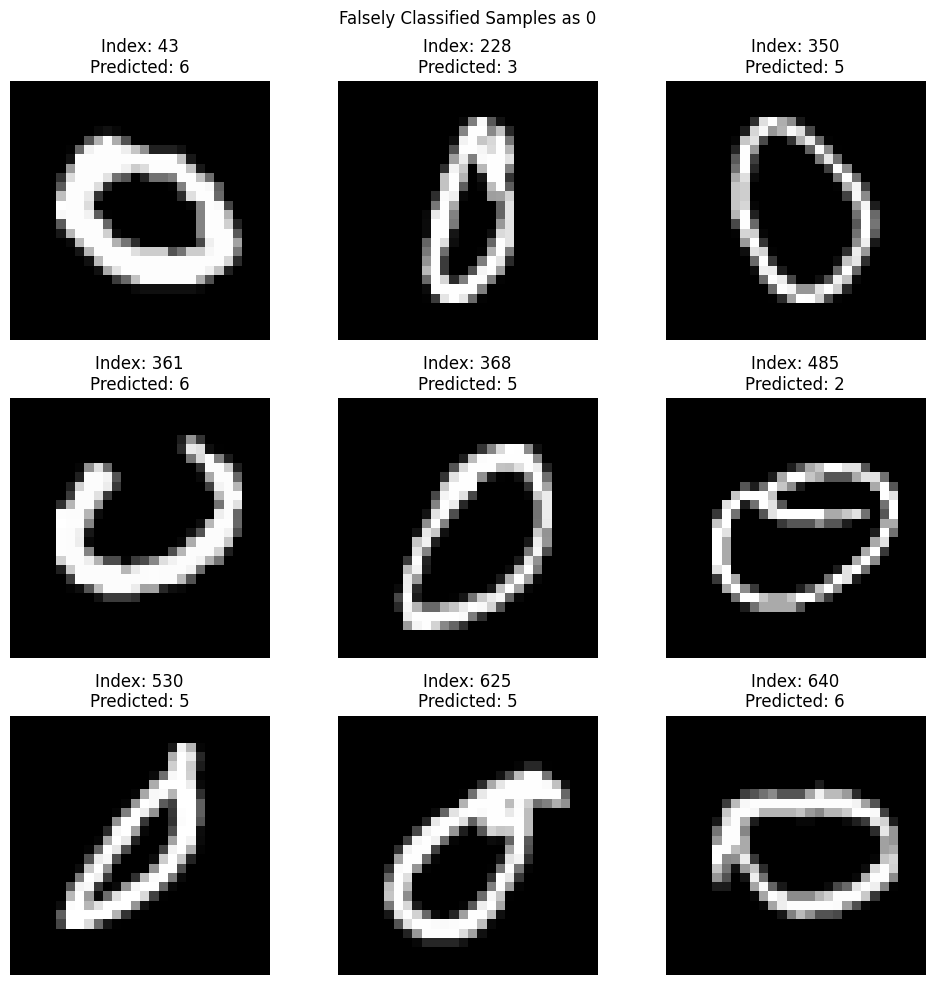

In [30]:
# Get the indices of the falsely classified samples as 0
false_indices = [i for i in range(len(y_test)) if y_test[i] == 0 and y_pred[i] != 0]

# Plot the first 9 falsely classified samples
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle('Falsely Classified Samples as 0')

for i, index in enumerate(false_indices[:9]):
    ax = axs[i // 3, i % 3]
    ax.imshow(X_test[index].reshape(28, 28), cmap='gray')
    ax.set_title(f'Index: {index}\nPredicted: {y_pred[index]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

(classified as zero but not zero)

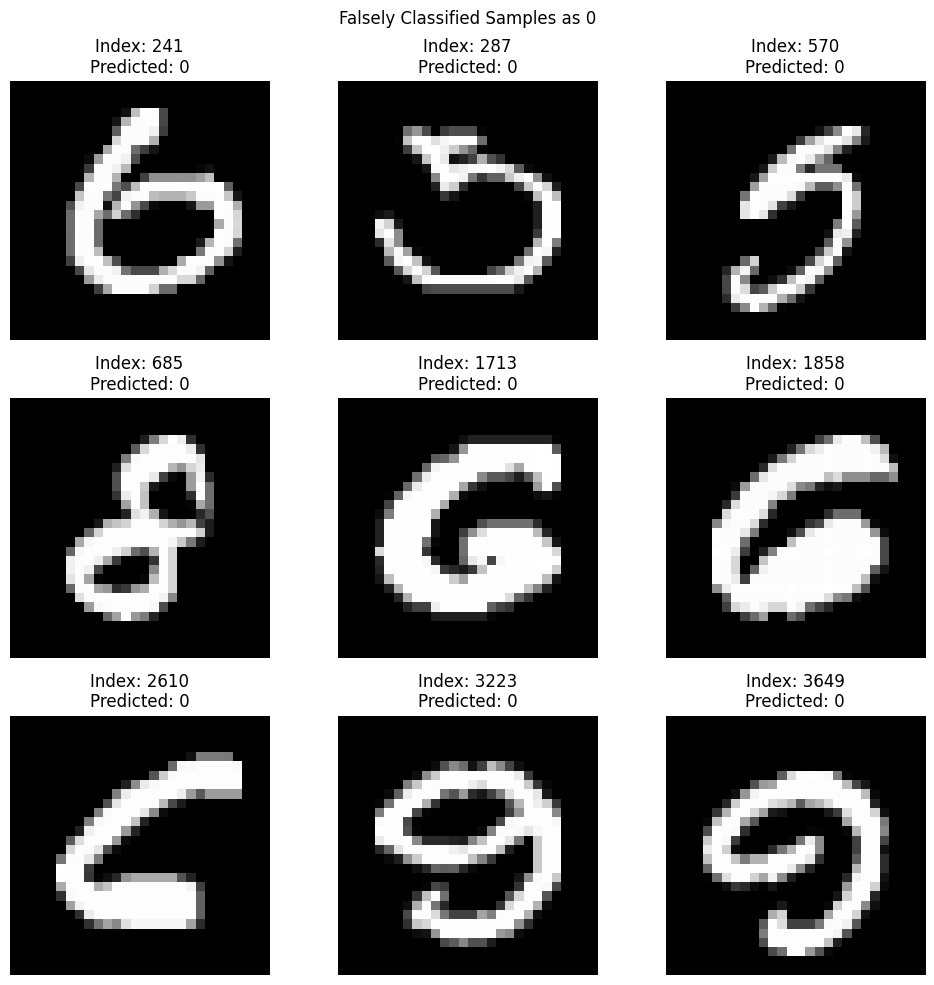

In [31]:

false_indices = [i for i in range(len(y_test)) if y_test[i] != 0 and y_pred[i] == 0]

# Plot the first 9 falsely classified samples
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle('Falsely Classified Samples as 0')

for i, index in enumerate(false_indices[:9]):
    ax = axs[i // 3, i % 3]
    ax.imshow(X_test[index].reshape(28, 28), cmap='gray')
    ax.set_title(f'Index: {index}\nPredicted: {y_pred[index]}')
    ax.axis('off')

plt.tight_layout()
plt.show()